## **Custom Binning (Domain Binning)**
*This binning technique is used when the creation of bins are based on `domain knowledge`.*

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np

# Load dataset
data = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Preprocessing
data = data[['Age', 'Survived']].dropna()
data.head()

,Age,Survived
0,22.0,0
1,38.0,1
2,26.0,1
3,35.0,1
4,35.0,0


In [2]:
# create custom bins
age_bins = [0, 18, 60, 100]
age_labels = ['Child', 'Adult', 'Senior']

In [3]:
data['Age Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False) # right = False -> Right boundry condition is not considered in each bin

data.sample(5)

,Age,Survived,Age Group
723,50.0,0,Adult
554,22.0,1,Adult
16,2.0,0,Child
795,39.0,0,Adult
163,17.0,0,Child


---

## **Uniform Binning (Equal Width Binning)**
*This binning techniques is used when you dont have `domain knowledge`.*

In [4]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Preprocessing
df = df[['Age', 'Survived']].dropna()
df.head()

,Age,Survived
0,22.0,0
1,38.0,1
2,26.0,1
3,35.0,1
4,35.0,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df[['Age']], df['Survived'], test_size=0.2, random_state=42)

In [6]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

X_train_binned = pd.DataFrame(discretizer.fit_transform(X_train), columns=discretizer.get_feature_names_out())
X_test_binned = pd.DataFrame(discretizer.transform(X_test), columns=discretizer.get_feature_names_out())

X_train_binned.head()

,Age
0,1.0
1,1.0
2,1.0
3,2.0
4,1.0


In [7]:
discretizer.bin_edges_ # ( 0.42 to 16.336, ...)

array([array([ 0.42 , 16.336, 32.252, 48.168, 64.084, 80.   ])],
      dtype=object)

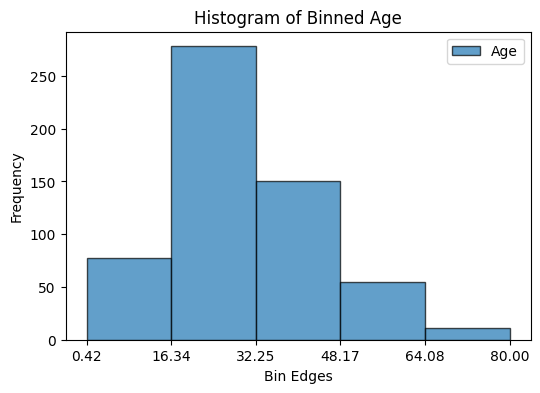

In [8]:
import matplotlib.pyplot as plt

# Extract the bin edges for the 'Age' feature from the nested array structure
age_bin_edges = discretizer.bin_edges_[0]

plt.figure(figsize=(6, 4))
# Use the extracted bin edges for plotting
plt.hist(X_train['Age'], bins=age_bin_edges, alpha=0.7, edgecolor='black', label='Age')
plt.title('Histogram of Binned Age')
plt.xlabel('Bin Edges')
plt.ylabel('Frequency')
plt.xticks(age_bin_edges)
plt.legend()
plt.show()

### Pipeline Construction
- Age: Missing Value Imputation
- Age: Descritezation
- Gender: OHE

In [9]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Preprocessing
df = df[['Age', 'Sex', 'Survived']]
df.head()

,Age,Sex,Survived
0,22.0,male,0
1,38.0,female,1
2,26.0,female,1
3,35.0,female,1
4,35.0,male,0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df[['Age', 'Sex']], df['Survived'], test_size=0.2, random_state=42)

*Way to apply myltiple operations on a single column*

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Pipeline for processing the 'Age' column
age_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with the median
    ('binning', KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform'))  # Then bin the data
])

In [12]:
# ColumnTransformer for applying different transformations
preprocessor = ColumnTransformer(transformers=[
    ('age', age_pipeline, ['Age']),  # Apply age_pipeline to 'Age'
    ('sex', OneHotEncoder(), ['Sex'])  # Apply OneHotEncoder to 'Sex'
])

In [13]:
from sklearn.linear_model import LogisticRegression

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())  # Use logistic regression as the model
])

In [14]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('age',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('binning',
                                                                   KBinsDiscretizer(encode='ordinal',
                                                                                    n_bins=3,
                                                                                    strategy='uniform'))]),
                                                  ['Age']),
                                                 ('sex', OneHotEncoder(),
                                                  ['Sex'])])),
                ('model', LogisticRegression())])

### Disadvantages
1. Effect of Outliers

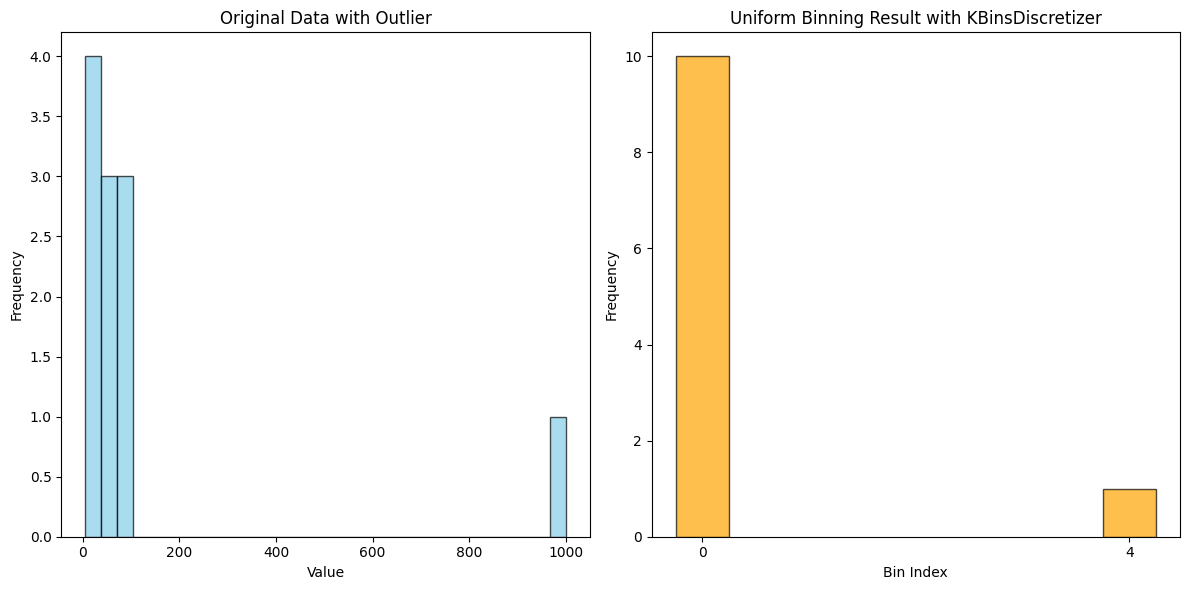

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Generating a dataset with values mostly between 0 and 100, with one outlier at 1000
data = np.array([5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 1000])

# Reshape data for KBinsDiscretizer
data_reshaped = data.reshape(-1, 1)  # Convert to 2D array for KBinsDiscretizer

# Define the number of bins
n_bins = 5

# Initialize KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

# Fit and transform the data
data_binned = discretizer.fit_transform(data_reshaped).ravel()  # Flatten back to 1D array for plotting

# Plotting the original data and the binned result
plt.figure(figsize=(12, 6))

# Plotting the original data
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Original Data with Outlier')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plotting the histogram after uniform binning with KBinsDiscretizer
plt.subplot(1, 2, 2)
# Calculate the counts for each bin for plotting
unique_bins = np.unique(data_binned)
bin_counts = [np.sum(data_binned == b) for b in unique_bins]
plt.bar(unique_bins, bin_counts, width=0.5, color='orange', alpha=0.7, edgecolor='black', align='center')
plt.title('Uniform Binning Result with KBinsDiscretizer')
plt.xlabel('Bin Index')
plt.ylabel('Frequency')
plt.xticks(unique_bins)  # Ensure x-ticks correspond to bin indices

plt.tight_layout()
plt.show()


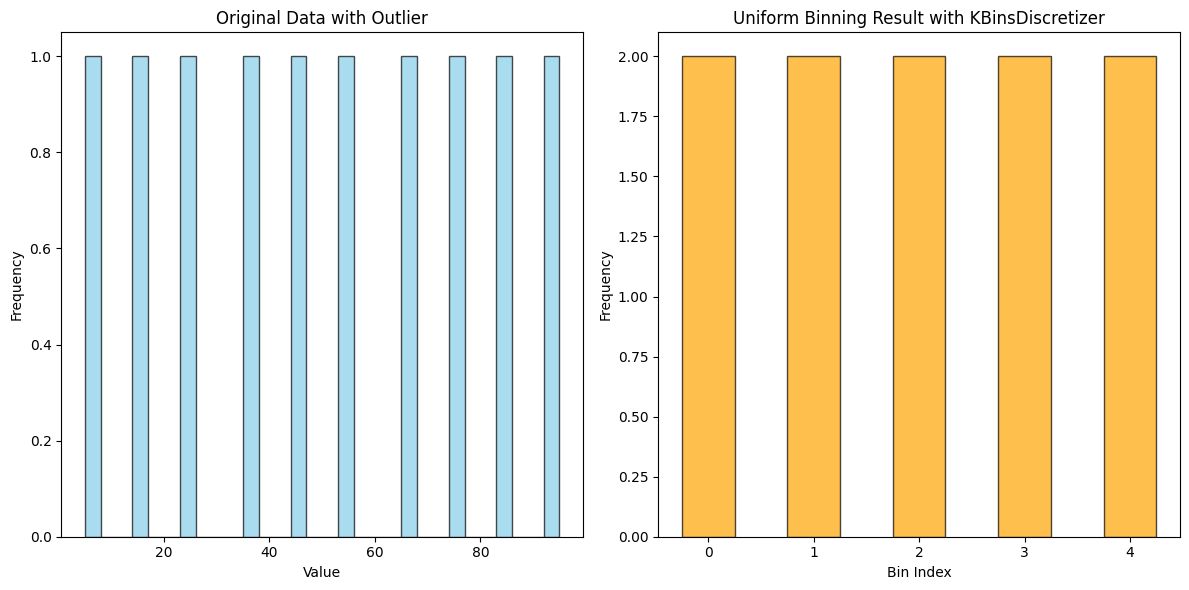

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Generating a dataset with values mostly between 0 and 100, with one outlier at 1000
data = np.array([5, 15, 25, 35, 45, 55, 65, 75, 85, 95])

# Reshape data for KBinsDiscretizer
data_reshaped = data.reshape(-1, 1)  # Convert to 2D array for KBinsDiscretizer

# Define the number of bins
n_bins = 5

# Initialize KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

# Fit and transform the data
data_binned = discretizer.fit_transform(data_reshaped).ravel()  # Flatten back to 1D array for plotting

# Plotting the original data and the binned result
plt.figure(figsize=(12, 6))

# Plotting the original data
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Original Data with Outlier')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plotting the histogram after uniform binning with KBinsDiscretizer
plt.subplot(1, 2, 2)
# Calculate the counts for each bin for plotting
unique_bins = np.unique(data_binned)
bin_counts = [np.sum(data_binned == b) for b in unique_bins]
plt.bar(unique_bins, bin_counts, width=0.5, color='orange', alpha=0.7, edgecolor='black', align='center')
plt.title('Uniform Binning Result with KBinsDiscretizer')
plt.xlabel('Bin Index')
plt.ylabel('Frequency')
plt.xticks(unique_bins)  # Ensure x-ticks correspond to bin indices

plt.tight_layout()
plt.show()


2. Distribution Loss

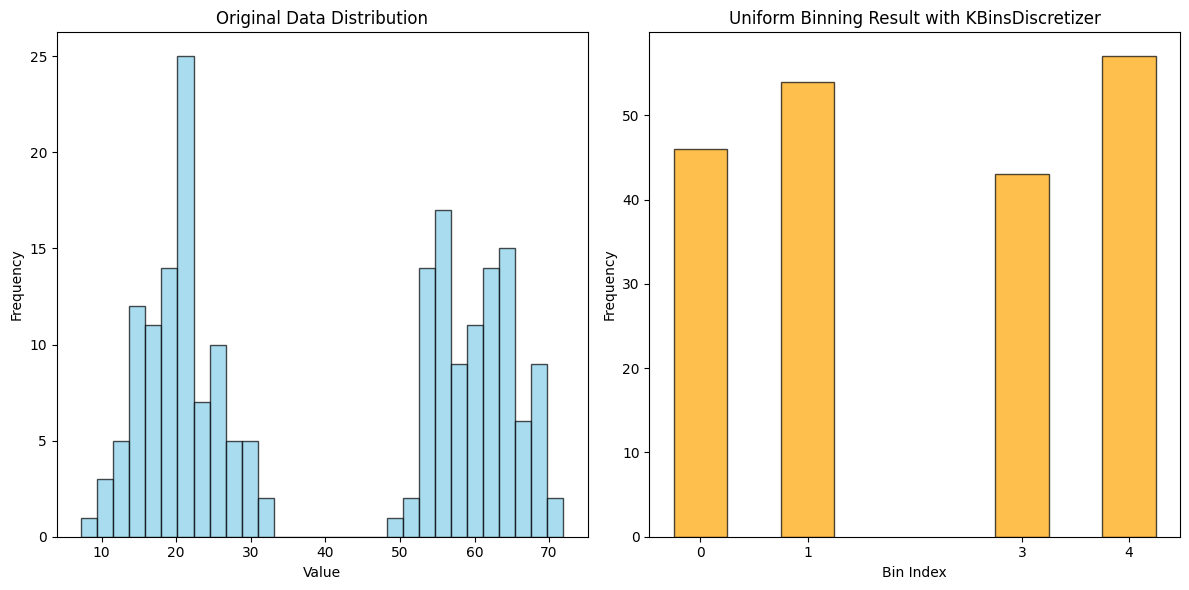

In [17]:
# problem 2 - not adaptive

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Seed for reproducibility
np.random.seed(0)

# Generating two clusters of data
data_cluster_1 = np.random.normal(loc=20, scale=5, size=100)  # Cluster 1 centered around 20
data_cluster_2 = np.random.normal(loc=60, scale=5, size=100)  # Cluster 2 centered around 60

# Combining the two clusters into a single dataset
data = np.concatenate([data_cluster_1, data_cluster_2])

# Reshape data for KBinsDiscretizer
data_reshaped = data.reshape(-1, 1)  # Convert to 2D array for KBinsDiscretizer

# Initialize KBinsDiscretizer for uniform binning
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

# Fit and transform the data
data_binned = discretizer.fit_transform(data_reshaped).ravel()  # Flatten back to 1D array for plotting

# Plotting the original data distribution and the binned result
plt.figure(figsize=(12, 6))

# Plotting the original data distribution
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(data, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Original Data Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plotting the histogram after uniform binning with KBinsDiscretizer
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# For each unique bin, count the occurrences and plot
unique_bins = np.unique(data_binned)
bin_counts = [np.sum(data_binned == b) for b in unique_bins]
plt.bar(unique_bins, bin_counts, width=0.5, color='orange', alpha=0.7, edgecolor='black', align='center')
plt.title('Uniform Binning Result with KBinsDiscretizer')
plt.xlabel('Bin Index')
plt.ylabel('Frequency')
plt.xticks(unique_bins)  # Ensure x-ticks correspond to bin indices

plt.tight_layout()
plt.show()


3. perfect number of bins

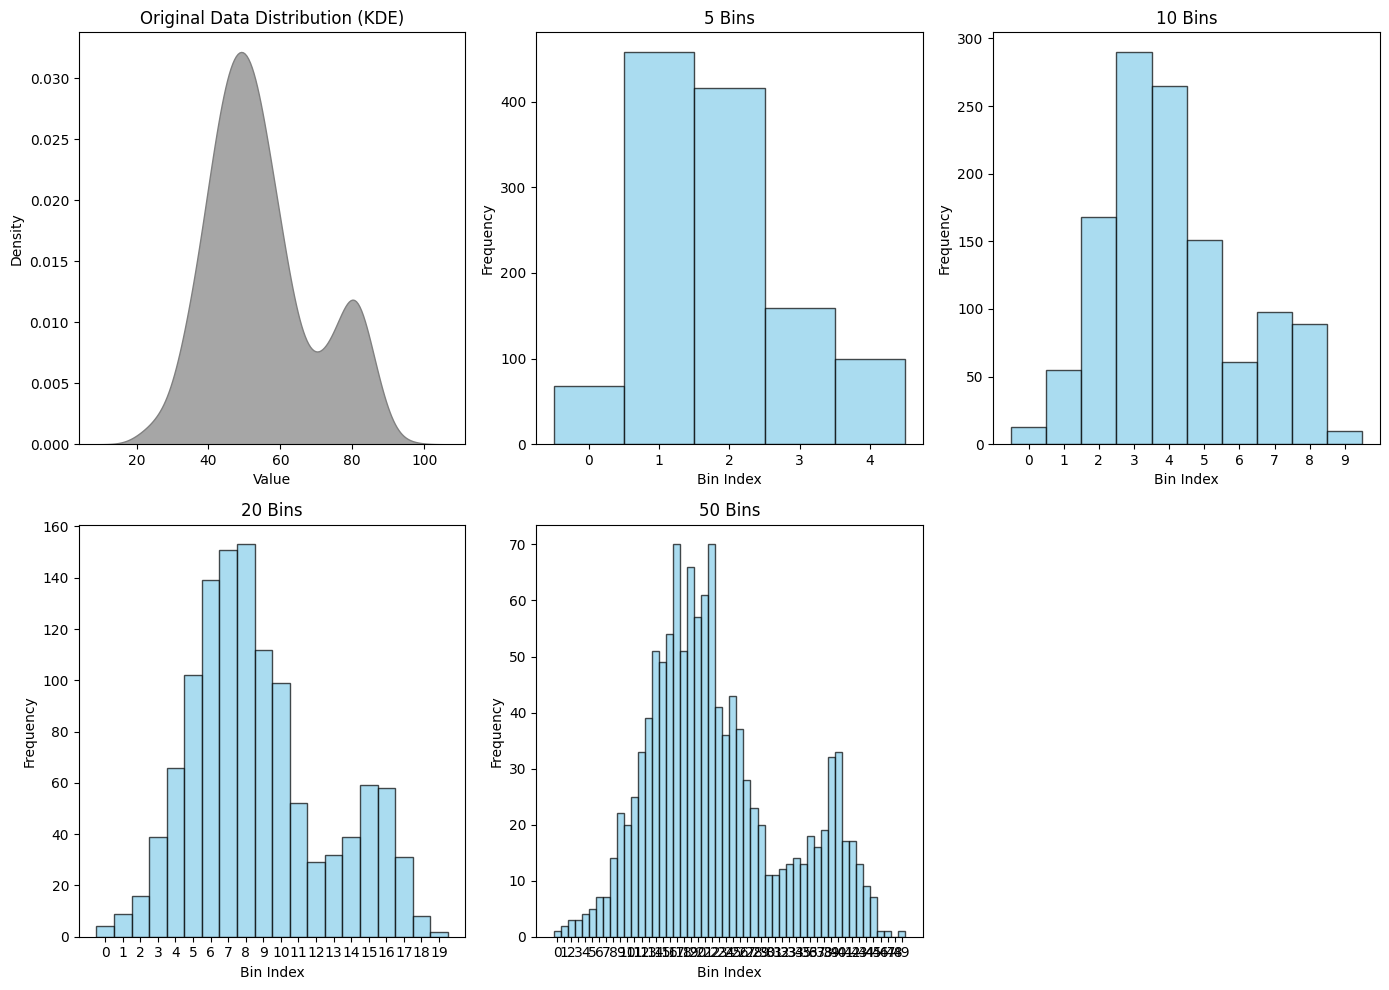

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

# Seed for reproducibility
np.random.seed(0)

# Generate a normally distributed dataset with an additional cluster
data_normal = np.random.normal(loc=50, scale=10, size=1000)
data_cluster = np.random.normal(loc=80, scale=5, size=200)
data = np.concatenate([data_normal, data_cluster]).reshape(-1, 1)  # Reshape for KBinsDiscretizer

# Different choices for the number of bins
bin_choices = [5, 10, 20, 50]

plt.figure(figsize=(14, 10))

# Plot the original data distribution using KDE
plt.subplot(2, 3, 1)
sns.kdeplot(data[:, 0], fill=True, color='gray', alpha=0.7)
plt.title('Original Data Distribution (KDE)')
plt.xlabel('Value')
plt.ylabel('Density')

# Apply KBinsDiscretizer and plot histograms for each bin choice
for i, n_bins in enumerate(bin_choices, start=2):
    # Initialize and fit the KBinsDiscretizer
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    data_binned = discretizer.fit_transform(data)

    # Plot histogram of the binned data
    plt.subplot(2, 3, i)
    # We plot the binned data by the bin indices and need to calculate the bin width for plotting
    bin_edges = discretizer.bin_edges_[0]
    plt.hist(data_binned, bins=np.arange(len(bin_edges)), align='left', color='skyblue', alpha=0.7, edgecolor='black')
    plt.title(f'{n_bins} Bins')
    plt.xlabel('Bin Index')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(len(bin_edges) - 1))

plt.tight_layout()
plt.show()


---

## **Quantile Binning**

In [20]:
data = np.array([22, 25, 27, 28, 30, 31, 34, 38, 43, 45, 49, 55])
data

array([22, 25, 27, 28, 30, 31, 34, 38, 43, 45, 49, 55])

In [21]:
np.percentile(data, 25)

np.float64(27.75)

In [22]:
np.percentile(data, 50)

np.float64(32.5)

In [23]:
np.percentile(data, 75)

np.float64(43.5)

In [24]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Preprocessing
df = df[['Age', 'Survived']].dropna()

df.head()

,Age,Survived
0,22.0,0
1,38.0,1
2,26.0,1
3,35.0,1
4,35.0,0


In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[['Age']], df['Survived'], test_size=0.2, random_state=42)

In [27]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

X_train_binned = pd.DataFrame(discretizer.fit_transform(X_train), columns=discretizer.get_feature_names_out())
X_test_binned = pd.DataFrame(discretizer.transform(X_test), columns=discretizer.get_feature_names_out())

X_train_binned.head()

,Age
0,2.0
1,2.0
2,2.0
3,3.0
4,2.0


In [28]:
discretizer.bin_edges_

array([array([ 0.42, 19.  , 25.  , 32.  , 42.  , 80.  ])], dtype=object)

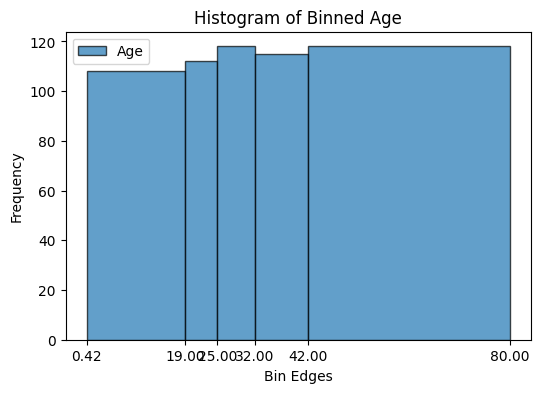

In [29]:
# Extract the bin edges for the 'Age' feature from the nested array structure
age_bin_edges = discretizer.bin_edges_[0]

plt.figure(figsize=(6, 4))
# Use the extracted bin edges for plotting
plt.hist(X_train['Age'], bins=age_bin_edges, alpha=0.7, edgecolor='black', label='Age')
plt.title('Histogram of Binned Age')
plt.xlabel('Bin Edges')
plt.ylabel('Frequency')
plt.xticks(age_bin_edges)
plt.legend()
plt.show()

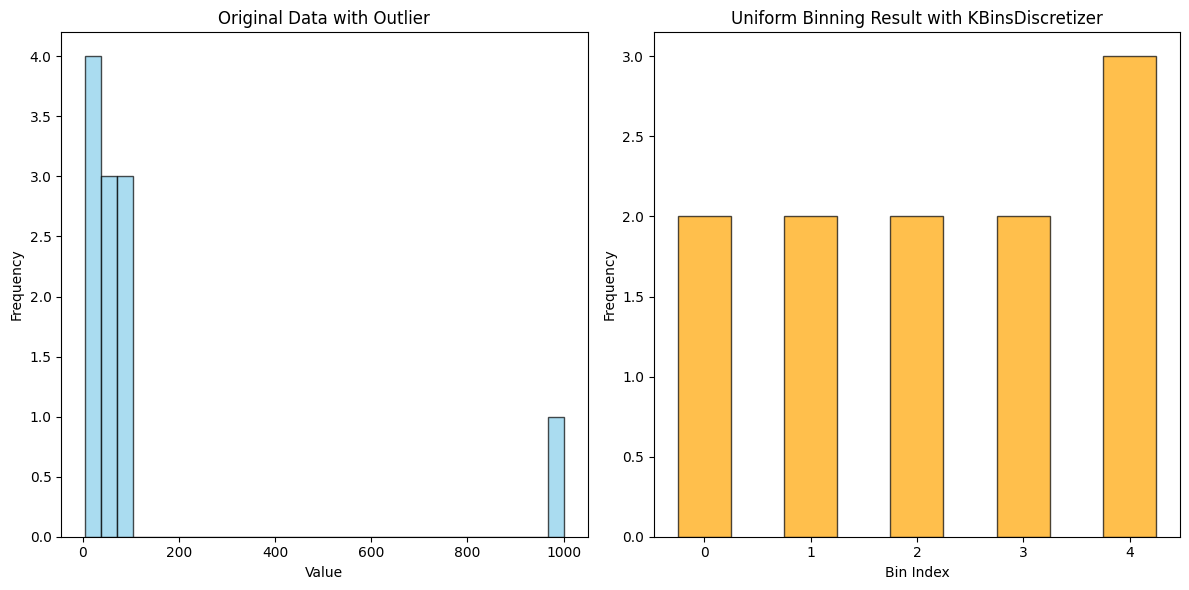

In [30]:
# impact of outlliers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Generating a dataset with values mostly between 0 and 100, with one outlier at 1000
data = np.array([5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 1000])

# Reshape data for KBinsDiscretizer
data_reshaped = data.reshape(-1, 1)  # Convert to 2D array for KBinsDiscretizer

# Define the number of bins
n_bins = 5

# Initialize KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')

# Fit and transform the data
data_binned = discretizer.fit_transform(data_reshaped).ravel()  # Flatten back to 1D array for plotting

# Plotting the original data and the binned result
plt.figure(figsize=(12, 6))

# Plotting the original data
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Original Data with Outlier')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plotting the histogram after uniform binning with KBinsDiscretizer
plt.subplot(1, 2, 2)
# Calculate the counts for each bin for plotting
unique_bins = np.unique(data_binned)
bin_counts = [np.sum(data_binned == b) for b in unique_bins]
plt.bar(unique_bins, bin_counts, width=0.5, color='orange', alpha=0.7, edgecolor='black', align='center')
plt.title('Uniform Binning Result with KBinsDiscretizer')
plt.xlabel('Bin Index')
plt.ylabel('Frequency')
plt.xticks(unique_bins)  # Ensure x-ticks correspond to bin indices

plt.tight_layout()
plt.show()

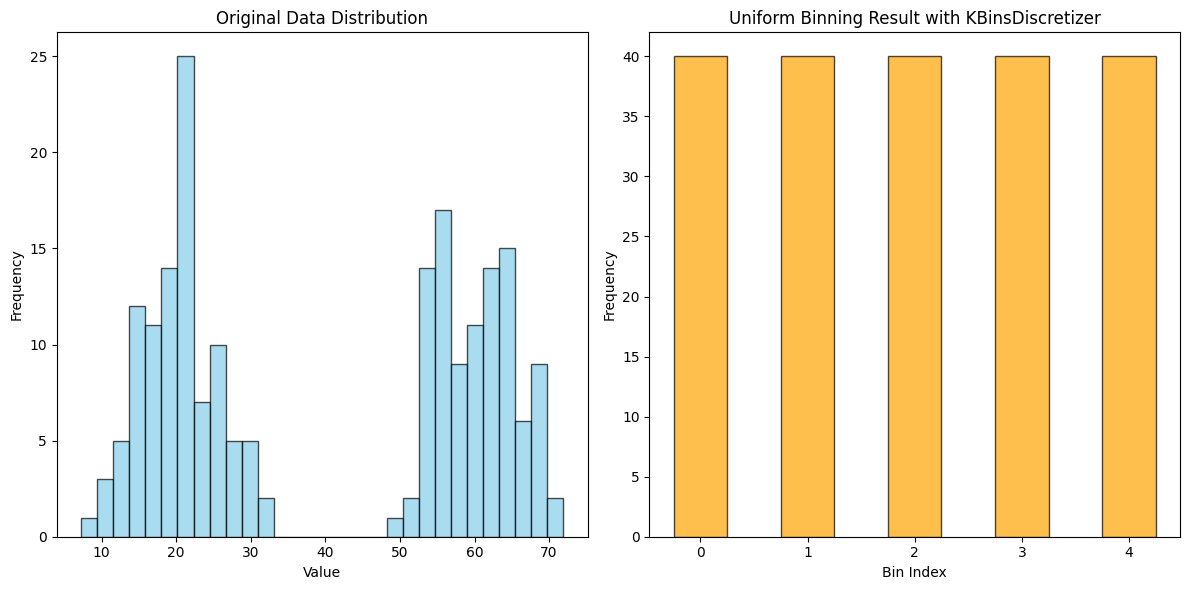

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Seed for reproducibility
np.random.seed(0)

# Generating two clusters of data
data_cluster_1 = np.random.normal(loc=20, scale=5, size=100)  # Cluster 1 centered around 20
data_cluster_2 = np.random.normal(loc=60, scale=5, size=100)  # Cluster 2 centered around 60

# Combining the two clusters into a single dataset
data = np.concatenate([data_cluster_1, data_cluster_2])

# Reshape data for KBinsDiscretizer
data_reshaped = data.reshape(-1, 1)  # Convert to 2D array for KBinsDiscretizer

# Initialize KBinsDiscretizer for uniform binning
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

# Fit and transform the data
data_binned = discretizer.fit_transform(data_reshaped).ravel()  # Flatten back to 1D array for plotting

# Plotting the original data distribution and the binned result
plt.figure(figsize=(12, 6))

# Plotting the original data distribution
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(data, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Original Data Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plotting the histogram after uniform binning with KBinsDiscretizer
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# For each unique bin, count the occurrences and plot
unique_bins = np.unique(data_binned)
bin_counts = [np.sum(data_binned == b) for b in unique_bins]
plt.bar(unique_bins, bin_counts, width=0.5, color='orange', alpha=0.7, edgecolor='black', align='center')
plt.title('Uniform Binning Result with KBinsDiscretizer')
plt.xlabel('Bin Index')
plt.ylabel('Frequency')
plt.xticks(unique_bins)  # Ensure x-ticks correspond to bin indices

plt.tight_layout()
plt.show()

Distribution Loose

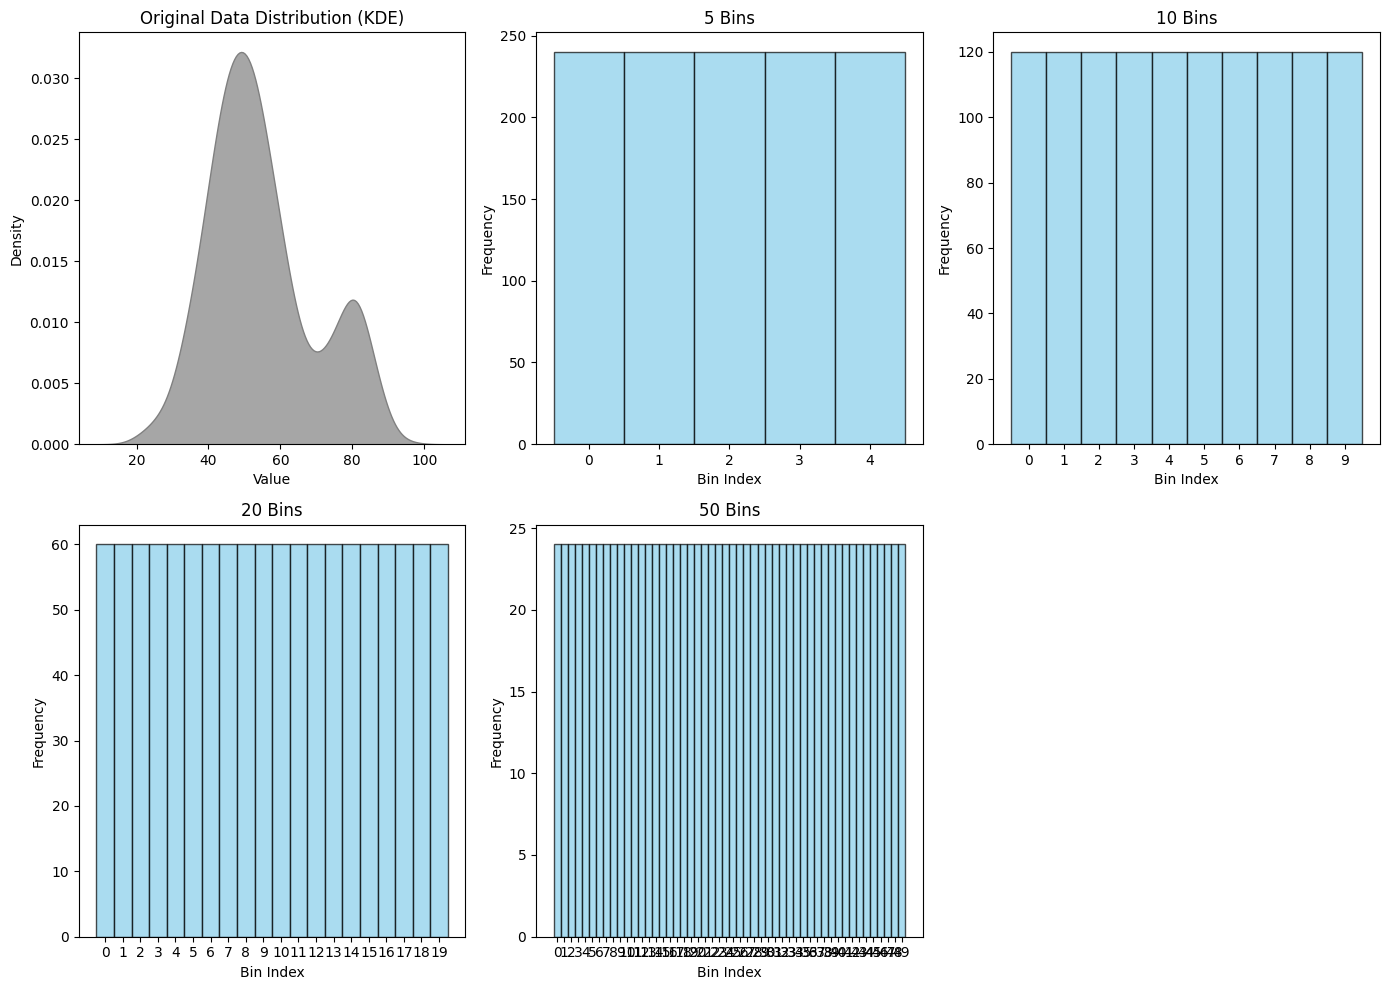

In [32]:
# Problem #3 - Seelcting # of bins

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

# Seed for reproducibility
np.random.seed(0)

# Generate a normally distributed dataset with an additional cluster
data_normal = np.random.normal(loc=50, scale=10, size=1000)
data_cluster = np.random.normal(loc=80, scale=5, size=200)
data = np.concatenate([data_normal, data_cluster]).reshape(-1, 1)  # Reshape for KBinsDiscretizer

# Different choices for the number of bins
bin_choices = [5, 10, 20, 50]

plt.figure(figsize=(14, 10))

# Plot the original data distribution using KDE
plt.subplot(2, 3, 1)
sns.kdeplot(data[:, 0], fill=True, color='gray', alpha=0.7)
plt.title('Original Data Distribution (KDE)')
plt.xlabel('Value')
plt.ylabel('Density')

# Apply KBinsDiscretizer and plot histograms for each bin choice
for i, n_bins in enumerate(bin_choices, start=2):
    # Initialize and fit the KBinsDiscretizer
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    data_binned = discretizer.fit_transform(data)

    # Plot histogram of the binned data
    plt.subplot(2, 3, i)
    # We plot the binned data by the bin indices and need to calculate the bin width for plotting
    bin_edges = discretizer.bin_edges_[0]
    plt.hist(data_binned, bins=np.arange(len(bin_edges)), align='left', color='skyblue', alpha=0.7, edgecolor='black')
    plt.title(f'{n_bins} Bins')
    plt.xlabel('Bin Index')
    plt.ylabel('Frequency')
    plt.xticks(np.arange(len(bin_edges) - 1))

plt.tight_layout()
plt.show()

*Problem - If same number have higher frequency then that same number fall in different bins -> data [1, 2, 3, 3, 3]*

---

## **KMeans Binning**

In [33]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Preprocessing
df = df[['Age', 'Survived']].dropna()

df.head()

,Age,Survived
0,22.0,0
1,38.0,1
2,26.0,1
3,35.0,1
4,35.0,0


In [35]:
X_train, X_test, y_train, y_test = train_test_split(df[['Age']], df['Survived'], test_size=0.2, random_state=42)

In [36]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')

X_train_binned = pd.DataFrame(discretizer.fit_transform(X_train), columns=discretizer.get_feature_names_out())
X_test_binned = pd.DataFrame(discretizer.transform(X_test), columns=discretizer.get_feature_names_out())

X_train_binned.head()

,Age
0,2.0
1,1.0
2,2.0
3,2.0
4,1.0


In [37]:
discretizer.bin_edges_

array([array([ 0.42      , 12.69636862, 27.02765256, 39.35418895, 54.21464646,
              80.        ])                                                   ],
      dtype=object)

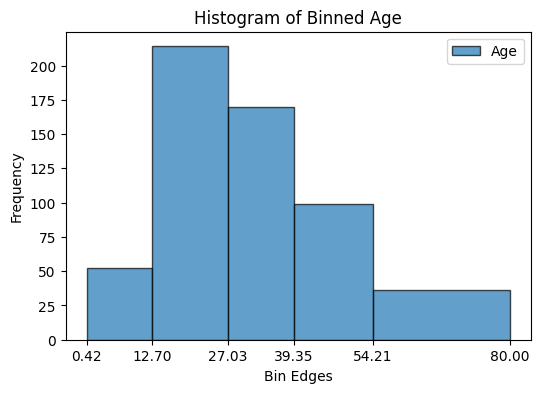

In [38]:
import matplotlib.pyplot as plt

# Extract the bin edges for the 'Age' feature from the nested array structure
age_bin_edges = discretizer.bin_edges_[0]

plt.figure(figsize=(6, 4))
# Use the extracted bin edges for plotting
plt.hist(X_train['Age'], bins=age_bin_edges, alpha=0.7, edgecolor='black', label='Age')
plt.title('Histogram of Binned Age')
plt.xlabel('Bin Edges')
plt.ylabel('Frequency')
plt.xticks(age_bin_edges)
plt.legend()
plt.show()

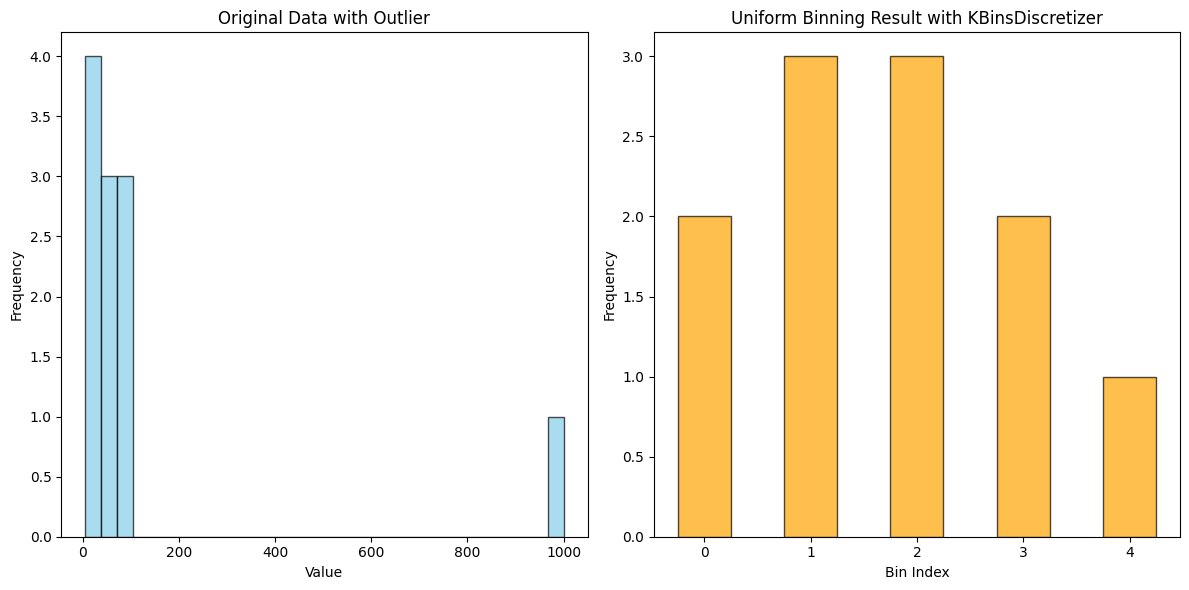

In [39]:
# impact of outlliers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Generating a dataset with values mostly between 0 and 100, with one outlier at 1000
data = np.array([5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 1000])

# Reshape data for KBinsDiscretizer
data_reshaped = data.reshape(-1, 1)  # Convert to 2D array for KBinsDiscretizer

# Define the number of bins
n_bins = 5

# Initialize KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='kmeans')

# Fit and transform the data
data_binned = discretizer.fit_transform(data_reshaped).ravel()  # Flatten back to 1D array for plotting

# Plotting the original data and the binned result
plt.figure(figsize=(12, 6))

# Plotting the original data
plt.subplot(1, 2, 1)
plt.hist(data, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Original Data with Outlier')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plotting the histogram after uniform binning with KBinsDiscretizer
plt.subplot(1, 2, 2)
# Calculate the counts for each bin for plotting
unique_bins = np.unique(data_binned)
bin_counts = [np.sum(data_binned == b) for b in unique_bins]
plt.bar(unique_bins, bin_counts, width=0.5, color='orange', alpha=0.7, edgecolor='black', align='center')
plt.title('Uniform Binning Result with KBinsDiscretizer')
plt.xlabel('Bin Index')
plt.ylabel('Frequency')
plt.xticks(unique_bins)  # Ensure x-ticks correspond to bin indices

plt.tight_layout()
plt.show()


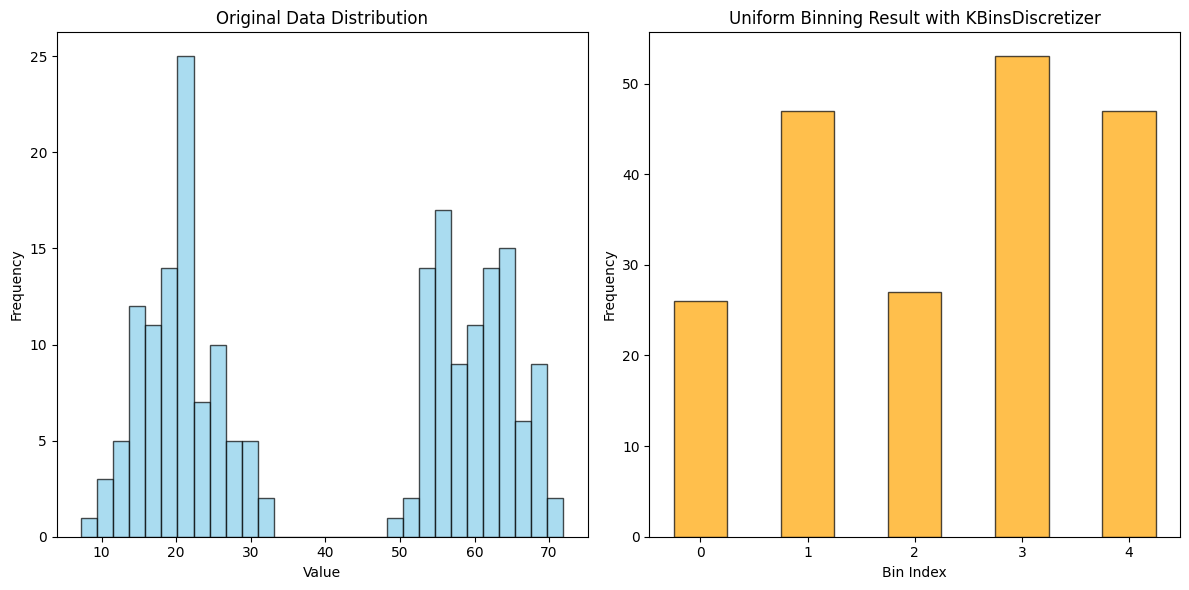

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Seed for reproducibility
np.random.seed(0)

# Generating two clusters of data
data_cluster_1 = np.random.normal(loc=20, scale=5, size=100)  # Cluster 1 centered around 20
data_cluster_2 = np.random.normal(loc=60, scale=5, size=100)  # Cluster 2 centered around 60

# Combining the two clusters into a single dataset
data = np.concatenate([data_cluster_1, data_cluster_2])

# Reshape data for KBinsDiscretizer
data_reshaped = data.reshape(-1, 1)  # Convert to 2D array for KBinsDiscretizer

# Initialize KBinsDiscretizer for uniform binning
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')

# Fit and transform the data
data_binned = discretizer.fit_transform(data_reshaped).ravel()  # Flatten back to 1D array for plotting

# Plotting the original data distribution and the binned result
plt.figure(figsize=(12, 6))

# Plotting the original data distribution
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(data, bins=30, color='skyblue', alpha=0.7, edgecolor='black')
plt.title('Original Data Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plotting the histogram after uniform binning with KBinsDiscretizer
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# For each unique bin, count the occurrences and plot
unique_bins = np.unique(data_binned)
bin_counts = [np.sum(data_binned == b) for b in unique_bins]
plt.bar(unique_bins, bin_counts, width=0.5, color='orange', alpha=0.7, edgecolor='black', align='center')
plt.title('Uniform Binning Result with KBinsDiscretizer')
plt.xlabel('Bin Index')
plt.ylabel('Frequency')
plt.xticks(unique_bins)  # Ensure x-ticks correspond to bin indices

plt.tight_layout()
plt.show()


---

## **Threshold Binning (Binarization)**

In [42]:
from sklearn.preprocessing import Binarizer

# Sample data
data = [[-1, 2, -3], [5, -6, 7]]

# Initialize the Binarizer with a threshold of 0
binarizer = Binarizer(threshold=0)

# Transform the data
binary_data = binarizer.fit_transform(data)
print(binary_data)

[[0 1 0]
 [1 0 1]]


## **Decision Tree Binning**

In [43]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Sample data (feature and target)
X = np.array([[6], [12], [14], [18], [22], [24], [29], [33], [37], [40]])
y = np.array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1])  # Binary target for simplicity

# Train a decision tree on the data
tree = DecisionTreeClassifier(max_leaf_nodes=4)  # Restricting tree size for simple binning
tree.fit(X, y)

DecisionTreeClassifier(max_leaf_nodes=4)

[Text(0.4, 0.875, 'x[0] <= 16.0\ngini = 0.48\nsamples = 10\nvalue = [4, 6]'),
 Text(0.2, 0.625, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.30000000000000004, 0.75, 'True  '),
 Text(0.6, 0.625, 'x[0] <= 26.5\ngini = 0.245\nsamples = 7\nvalue = [1, 6]'),
 Text(0.5, 0.75, '  False'),
 Text(0.4, 0.375, 'x[0] <= 23.0\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.2, 0.125, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.6, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8, 0.375, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]')]

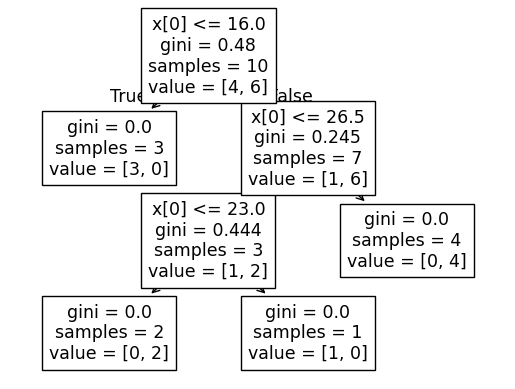

In [44]:
from sklearn.tree import plot_tree
plot_tree(tree)

In [45]:
# Extract split points (thresholds) from the tree to define bin edges
split_points = tree.tree_.threshold[tree.tree_.threshold != -2] # threshold = -2 represents leaf node
split_points

array([16. , 26.5, 23. ])

In [46]:
# Add the minimum and maximum values to cover the full range of X
bin_edges = np.sort(np.concatenate(([X.min()], split_points, [X.max()])))

print("Bin edges:", bin_edges)

Bin edges: [ 6.  16.  23.  26.5 40. ]


In [47]:
# Function to assign bins
def assign_bins(data, edges):
    bins = np.digitize(data, edges, right=False)  # Assign bins based on edges
    # Adjusting bins to be 1-indexed instead of 0-indexed
    # and ensuring values fall into n_bins categories
    bins = np.clip(bins, 1, len(edges)-1)
    return bins

In [48]:
# Assign each data point to a bin
bins_assigned = assign_bins(X, bin_edges)

# Print the assigned bins for each data point
for value, bin_num in zip(X.flatten(), bins_assigned):
    print(f"Value: {value} assigned to Bin: {bin_num}")

Value: 6 assigned to Bin: [1]
Value: 12 assigned to Bin: [1]
Value: 14 assigned to Bin: [1]
Value: 18 assigned to Bin: [2]
Value: 22 assigned to Bin: [2]
Value: 24 assigned to Bin: [3]
Value: 29 assigned to Bin: [4]
Value: 33 assigned to Bin: [4]
Value: 37 assigned to Bin: [4]
Value: 40 assigned to Bin: [4]
